In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Gasto diario promedio por ciudad (en USD)
daily_spending = {'Cartagena': 130, 'Medellín': 90, 'Bogotá': 110}
cities = list(daily_spending.keys())
n_per_city = 20

# Simular datos
data = []
for city in cities:
    for _ in range(n_per_city):
        days = np.random.randint(1, 8)  # entre 1 y 7 días
        daily = np.random.normal(loc=daily_spending[city], scale=10)
        total = days * daily
        data.append({'city': city, 'days': days, 'daily': daily, 'total_spending': total})

df = pd.DataFrame(data)


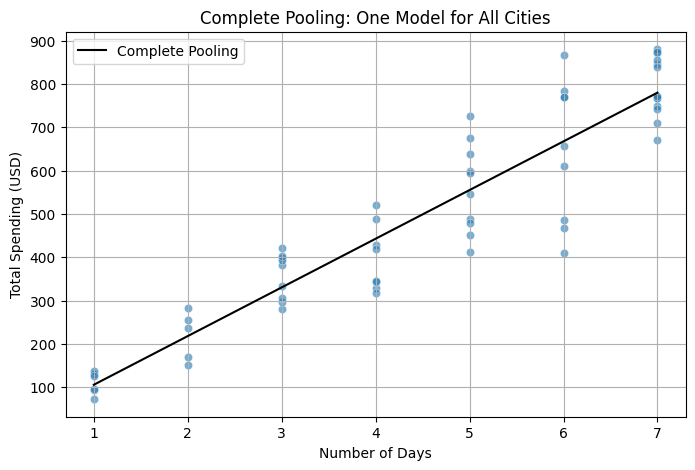

In [6]:
import statsmodels.api as sm

# Modelo sin distinguir ciudad
X = sm.add_constant(df['days'])
model_cp = sm.OLS(df['total_spending'], X).fit()

# Predicción
days_seq = np.linspace(1, 7, 100)
pred_cp = model_cp.predict(sm.add_constant(days_seq))

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='days', y='total_spending', alpha=0.6)
plt.plot(days_seq, pred_cp, color='black', label='Complete Pooling')
plt.title('Complete Pooling: One Model for All Cities')
plt.xlabel('Number of Days')
plt.ylabel('Total Spending (USD)')
plt.legend()
plt.grid(True)
plt.show()


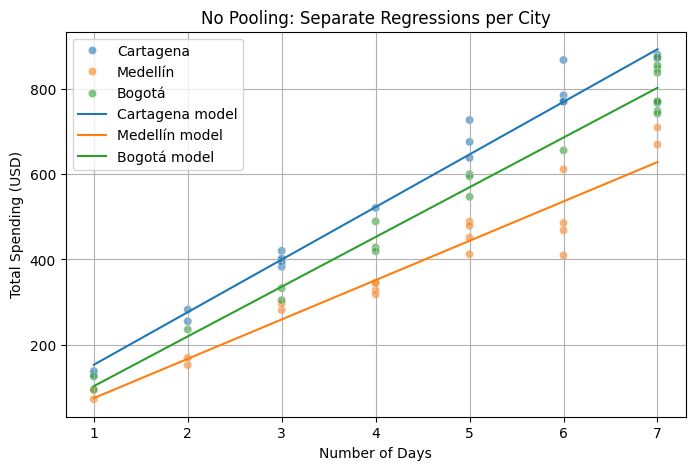

In [7]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='days', y='total_spending', hue='city', alpha=0.6)

for city in cities:
    df_city = df[df['city'] == city]
    X_city = sm.add_constant(df_city['days'])
    model_city = sm.OLS(df_city['total_spending'], X_city).fit()
    pred_city = model_city.predict(sm.add_constant(days_seq))
    plt.plot(days_seq, pred_city, label=f'{city} model')

plt.title('No Pooling: Separate Regressions per City')
plt.xlabel('Number of Days')
plt.ylabel('Total Spending (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener `df` del ejemplo anterior con columnas: 'city', 'days', 'total_spending'
cities = df['city'].unique()
city_idx = df['city'].astype('category').cat.codes.values  # map cities to integers

with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    beta_0 = pm.Normal('beta_0', mu=0, sigma=100)

    sigma_mu = pm.HalfNormal('sigma_mu', sigma=20)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=20)

    # Group-level effects
    mu = pm.Normal('mu', mu=mu_0, sigma=sigma_mu, shape=len(cities))
    beta = pm.Normal('beta', mu=beta_0, sigma=sigma_beta, shape=len(cities))

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=20)

    # Expected value
    y_hat = mu[city_idx] + beta[city_idx] * df['days'].values

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=sigma, observed=df['total_spending'])

    # Sampling
    trace = pm.sample(10000, tune=3000, target_accept=0.95, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, beta_0, sigma_mu, sigma_beta, mu, beta, sigma]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 35 seconds.
There were 1239 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
cities = df['city'].unique()

# Codificación de ciudades como categorías (y sus índices)
city_categories = df['city'].astype('category')
city_idx = city_categories.cat.codes.values
idx_to_city = dict(enumerate(city_categories.cat.categories))

/var/folders/qh/43yzjghs7pzb3lwh4m4rkxch0000gn/T/ipykernel_15533/1602358655.py:25: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(preds, hdi_prob=0.94)  # 94% es estándar en PyMC
/var/folders/qh/43yzjghs7pzb3lwh4m4rkxch0000gn/T/ipykernel_15533/1602358655.py:25: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(preds, hdi_prob=0.94)  # 94% es estándar en PyMC
/var/folders/qh/43yzjghs7pzb3lwh4m4rkxch0000gn/T/ipykernel_15533/1602358655.py:25: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(preds, hdi_prob=0.94)  # 94% es estándar en PyMC


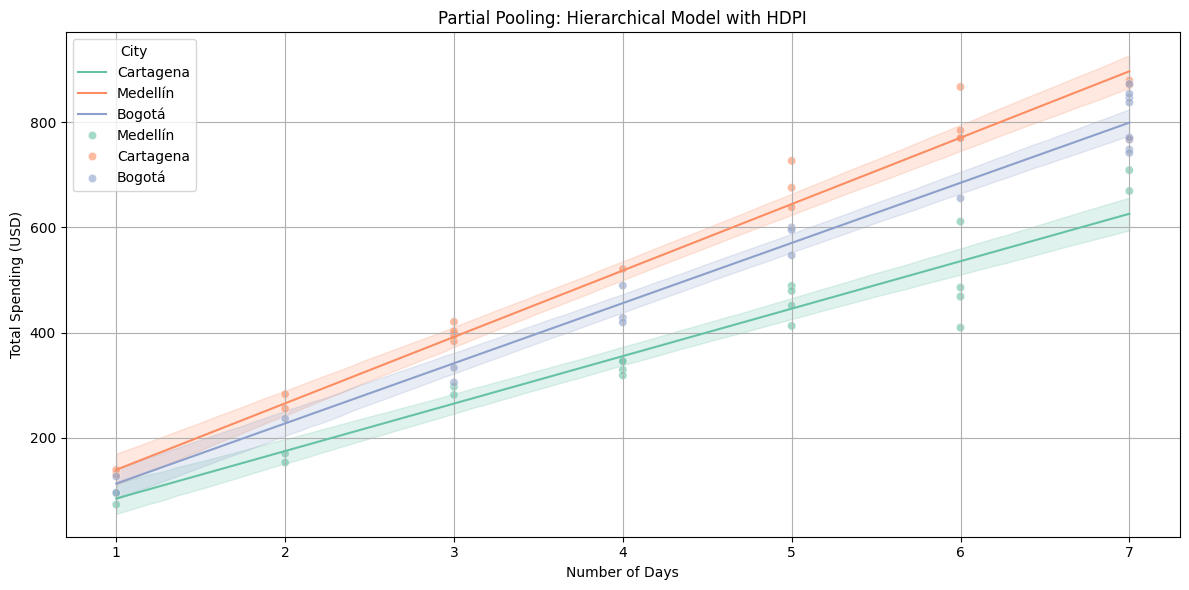

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Asegúrate de tener estas variables listas:
# - df: DataFrame con columnas 'city', 'days', 'total_spending'
# - posterior: resultado de trace.posterior
# - cities: lista con los nombres únicos de las ciudades

colors = sns.color_palette("Set2", len(cities))
days_seq = np.linspace(1, 7, 100)

plt.figure(figsize=(12, 6))

for i, city in enumerate(cities):
    # Extraer muestras de los parámetros por ciudad
    mu_samples = posterior['mu'].sel(mu_dim_0=i).values.flatten()
    beta_samples = posterior['beta'].sel(beta_dim_0=i).values.flatten()

    # Predicciones para cada muestra MCMC
    preds = np.outer(mu_samples, np.ones_like(days_seq)) + np.outer(beta_samples, days_seq)

    # Calcular el HDPI (intervalo de credibilidad)
    hdi = az.hdi(preds, hdi_prob=0.94)  # 94% es estándar en PyMC

    # Media de las predicciones
    mean_preds = preds.mean(axis=0)

    # Graficar media y HDPI
    plt.plot(days_seq, mean_preds, label=f"{city}", color=colors[i])
    plt.fill_between(days_seq, hdi[:, 0], hdi[:, 1], color=colors[i], alpha=0.2)

# Puntos reales
sns.scatterplot(data=df, x='days', y='total_spending', hue='city', palette=colors, alpha=0.6)

plt.title('Partial Pooling: Hierarchical Model with HDPI')
plt.xlabel('Number of Days')
plt.ylabel('Total Spending (USD)')
plt.legend(title="City")
plt.grid(True)
plt.tight_layout()
plt.show()


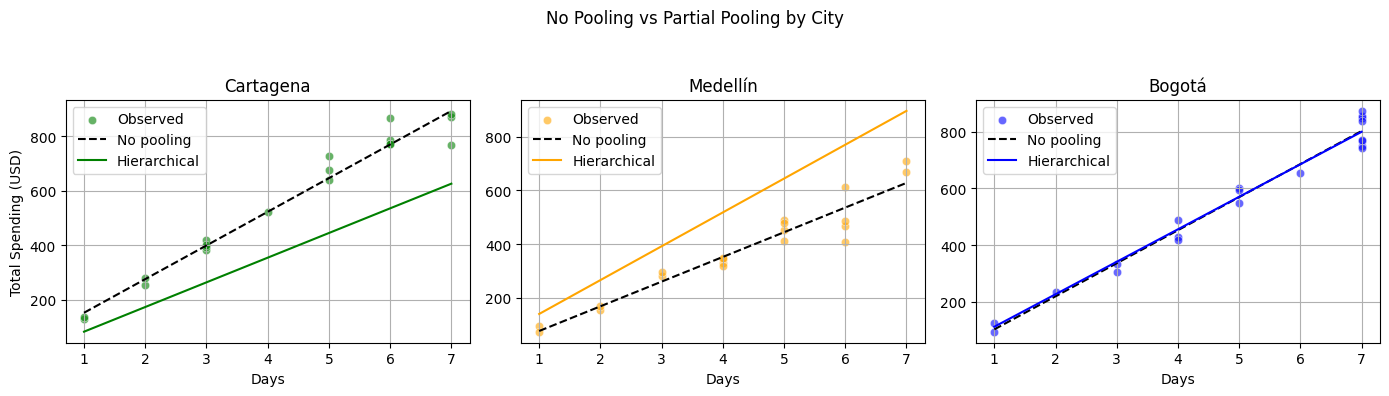

In [40]:
import statsmodels.api as sm

plt.figure(figsize=(14, 4))
colors = {'Cartagena': 'green', 'Medellín': 'orange', 'Bogotá': 'blue'}
days_seq = np.linspace(1, 7, 100)

for i, city in enumerate(cities):
    plt.subplot(1, 3, i+1)
    df_city = df[df['city'] == city]

    # Modelo No Pooling (OLS)
    X_city = sm.add_constant(df_city['days'])
    model_np = sm.OLS(df_city['total_spending'], X_city).fit()
    pred_np = model_np.predict(sm.add_constant(days_seq))

    # Partial Pooling con media posterior
    mu_post = posterior['mu'].sel(mu_dim_0=i).mean().values
    beta_post = posterior['beta'].sel(beta_dim_0=i).mean().values
    pred_pp = mu_post + beta_post * days_seq

    # Puntos reales
    sns.scatterplot(data=df_city, x='days', y='total_spending',
                    color=colors[city], alpha=0.6, label='Observed')

    # Líneas
    plt.plot(days_seq, pred_np, linestyle='--', color='black', label='No pooling')
    plt.plot(days_seq, pred_pp, linestyle='-', color=colors[city], label='Hierarchical')

    plt.title(f'{city}')
    plt.xlabel('Days')
    if i == 0:
        plt.ylabel('Total Spending (USD)')
    else:
        plt.ylabel('')
    plt.legend()
    plt.grid(True)

plt.suptitle('No Pooling vs Partial Pooling by City')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Asumimos que `df` tiene columnas: 'city', 'days', 'total_spending'
cities = df['city'].unique()
summary = []

for city in cities:
    df_city = df[df['city'] == city]
    X_city = sm.add_constant(df_city['days'])
    model_city = sm.OLS(df_city['total_spending'], X_city).fit()
    
    # Predicción para los mismos datos
    pred_mean = model_city.predict(sm.add_constant(df_city['days'])).mean()
    
    summary.append({
        'city': city,
        'y_observed': df_city['total_spending'].mean(),
        'y_rep': pred_mean
    })

summary_df = pd.DataFrame(summary)


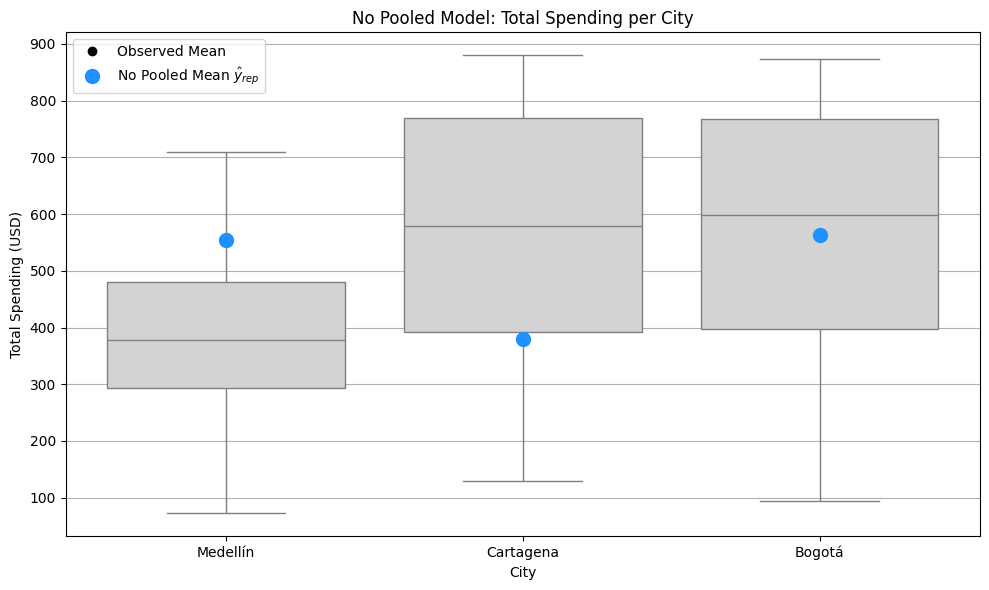

In [35]:
# Orden por gasto observado
ordered = summary_df.sort_values('y_observed')['city'].values
df['city'] = pd.Categorical(df['city'], categories=ordered, ordered=True)
summary_df['city'] = pd.Categorical(summary_df['city'], categories=ordered, ordered=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Boxplots
sns.boxplot(data=df, x='city', y='total_spending', ax=ax, color='lightgray')

# Medias observadas (punto negro)
ax.plot(np.arange(len(ordered)), summary_df['y_observed'], 'o', color='black', label='Observed Mean', markersize=6)

# Medias del modelo no pooled (punto azul claro)
ax.plot(np.arange(len(ordered)), summary_df['y_rep'], 'o', color='dodgerblue', label='No Pooled Mean $\hat{y}_{rep}$', markersize=10)

# Estética
ax.set_title('No Pooled Model: Total Spending per City')
ax.set_ylabel('Total Spending (USD)')
ax.set_xlabel('City')
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [36]:
# Importaciones necesarias
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cálculo del promedio de días por ciudad
mean_days = df.groupby('city')['days'].mean().reindex(cities)

# Acceso a posterior
mu_post = trace.posterior['mu'].mean(dim=["chain", "draw"]).values
beta_post = trace.posterior['beta'].mean(dim=["chain", "draw"]).values

# Cálculo de predicción esperada por ciudad: E[μ_j + β_j * mean(days_j)]
hier_preds = mu_post + beta_post * mean_days.values

# Crear tabla resumen
summary_hier = df.groupby('city')['total_spending'].mean().reset_index()
summary_hier.columns = ['city', 'y_observed']
summary_hier['y_hier'] = hier_preds


/var/folders/qh/43yzjghs7pzb3lwh4m4rkxch0000gn/T/ipykernel_15533/2214558269.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_days = df.groupby('city')['days'].mean().reindex(cities)
/var/folders/qh/43yzjghs7pzb3lwh4m4rkxch0000gn/T/ipykernel_15533/2214558269.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_hier = df.groupby('city')['total_spending'].mean().reset_index()


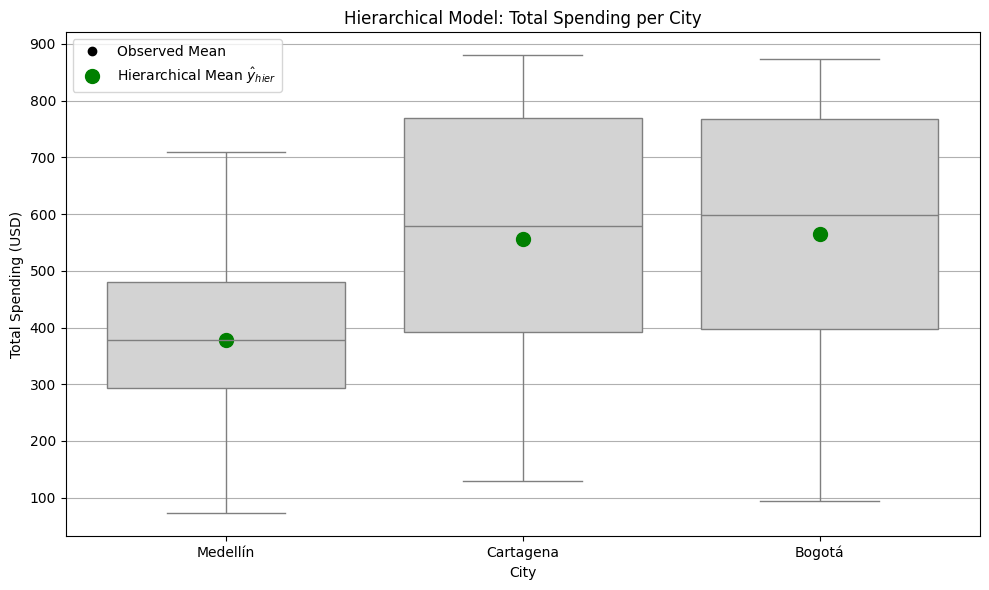

In [26]:
# Ordenar por media observada
ordered = summary_hier.sort_values('y_observed')['city'].values
df['city'] = pd.Categorical(df['city'], categories=ordered, ordered=True)
summary_hier['city'] = pd.Categorical(summary_hier['city'], categories=ordered, ordered=True)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Boxplots por ciudad
sns.boxplot(data=df, x='city', y='total_spending', ax=ax, color='lightgray')

# Media observada (negro)
ax.plot(np.arange(len(ordered)), summary_hier['y_observed'], 'o', color='black', label='Observed Mean', markersize=6)

# Media del modelo jerárquico (verde)
ax.plot(np.arange(len(ordered)), summary_hier['y_hier'], 'o', color='green', label='Hierarchical Mean $\hat{y}_{hier}$', markersize=10)

# Estética
ax.set_title('Hierarchical Model: Total Spending per City')
ax.set_ylabel('Total Spending (USD)')
ax.set_xlabel('City')
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [43]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Simulate original data
np.random.seed(42)
daily_spending = {'Cartagena': 130, 'Medellín': 90, 'Bogotá': 110}
cities = list(daily_spending.keys())
n_per_city = 20
data = []
for city in cities:
    for _ in range(n_per_city):
        days = np.random.randint(1, 8)
        daily = np.random.normal(loc=daily_spending[city], scale=10)
        total = days * daily
        data.append({'city': city, 'days': days, 'daily': daily, 'total_spending': total})
df = pd.DataFrame(data)

# Add new city with only one observation: Cali
df = pd.concat([df, pd.DataFrame([{'city': 'Cali', 'days': 5, 'daily': 100, 'total_spending': 500}])], ignore_index=True)

# Create new city codes
df['city_code'] = df['city'].astype('category').cat.codes
cities = df['city'].unique()
city_idx = df['city_code'].values

import numpy as np
import pandas as pd

# New data point: stay of 5 days
new_days = 5



# Corrección: solo predecimos para las ciudades que sí están en la muestra original
posterior = trace.posterior
original_cities = ['Cartagena', 'Medellín', 'Bogotá']  # orden consistente con los índices

# Nueva predicción para 5 días
new_days = 5
pp_preds = {}

for i, city in enumerate(original_cities):
    mu_samples = posterior['mu'].sel(mu_dim_0=i).values.flatten()
    beta_samples = posterior['beta'].sel(beta_dim_0=i).values.flatten()
    sigma_samples = posterior['sigma'].values.flatten()
    
    y_samples = mu_samples + beta_samples * new_days + np.random.normal(0, sigma_samples)
    pp_preds[city] = {
        'Predicted_Mean': np.mean(y_samples),
        'HDI_5%': np.percentile(y_samples, 5),
        'HDI_95%': np.percentile(y_samples, 95)
    }

# Para Cali, usamos los hiperparámetros globales mu_0 y beta_0
mu_0_samples = posterior['mu_0'].values.flatten()
beta_0_samples = posterior['beta_0'].values.flatten()
sigma_samples = posterior['sigma'].values.flatten()

y_cali_samples = mu_0_samples + beta_0_samples * new_days + np.random.normal(0, sigma_samples)
pp_preds['Cali'] = {
    'Predicted_Mean': np.mean(y_cali_samples),
    'HDI_5%': np.percentile(y_cali_samples, 5),
    'HDI_95%': np.percentile(y_cali_samples, 95)
}

# Mostrar predicciones en DataFrame
pp_preds_df = pd.DataFrame(pp_preds).T
pp_preds_df.index.name = 'City'
pp_preds_df



,Predicted_Mean,HDI_5%,HDI_95%
City,,,
Cartagena,445.523835,371.603089,520.253025
Medellín,644.465838,570.001139,719.222309
Bogotá,570.514704,497.264154,644.979019
Cali,545.277437,413.297676,674.345789


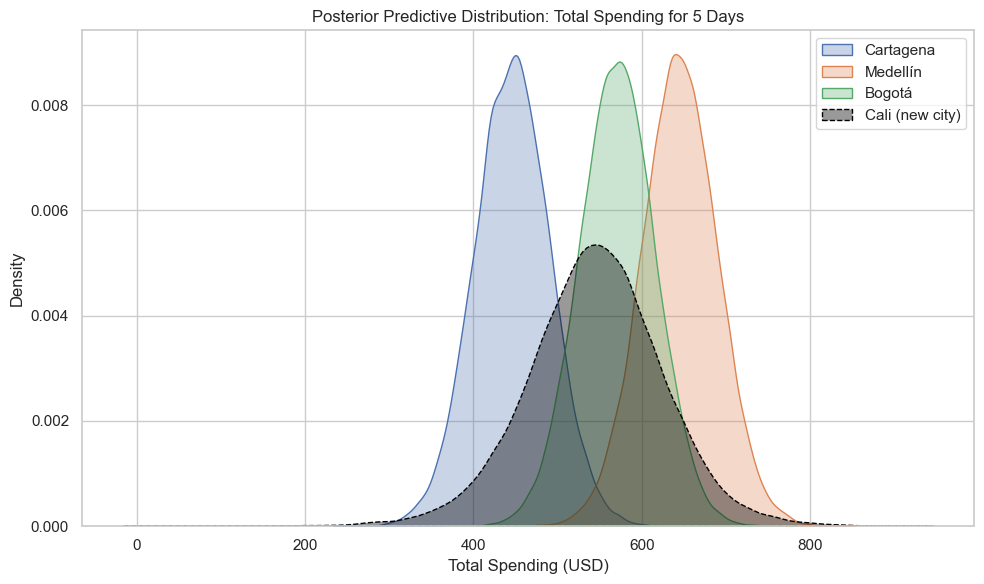

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Plot para ciudades del modelo
for i, city in enumerate(original_cities):
    mu_samples = posterior['mu'].sel(mu_dim_0=i).values.flatten()
    beta_samples = posterior['beta'].sel(beta_dim_0=i).values.flatten()
    sigma_samples = posterior['sigma'].values.flatten()
    
    y_samples = mu_samples + beta_samples * new_days + np.random.normal(0, sigma_samples)
    
    sns.kdeplot(y_samples, label=city, fill=True, alpha=0.3)

# Plot para Cali usando los hiperparámetros
mu_0_samples = posterior['mu_0'].values.flatten()
beta_0_samples = posterior['beta_0'].values.flatten()
sigma_samples = posterior['sigma'].values.flatten()

y_cali_samples = mu_0_samples + beta_0_samples * new_days + np.random.normal(0, sigma_samples)
sns.kdeplot(y_cali_samples, label='Cali (new city)', fill=True, color='black', alpha=0.4, linestyle='--')

# Gráfico final
plt.title("Posterior Predictive Distribution: Total Spending for 5 Days")
plt.xlabel("Total Spending (USD)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Define true parameters for each city
true_params = {
    'Cartagena': {'alpha': -2.0, 'beta': 0.7},
    'Medellín': {'alpha': 0.0, 'beta': 1.0},
    'Bogotá': {'alpha': 1.0, 'beta': 1.2},
}

n_per_city = 100
days_range = np.arange(1, 15)

# Generate synthetic dataset
data = []
for city, params in true_params.items():
    for _ in range(n_per_city):
        days = np.random.choice(days_range)
        linear_term = params['alpha'] + params['beta'] * days
        prob = 1 / (1 + np.exp(-linear_term))
        recommend = np.random.binomial(1, prob)
        data.append({
            'city': city,
            'days': days,
            'recommend': recommend
        })

df = pd.DataFrame(data)


In [99]:
df

,city,days,recommend
0,Cartagena,7,1
1,Cartagena,11,1
2,Cartagena,5,1
3,Cartagena,3,1
4,Cartagena,11,1
...,...,...,...
295,Bogotá,3,1
296,Bogotá,14,1
297,Bogotá,12,1
298,Bogotá,8,1


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nuevos parámetros para hacer más "sigmoidal"
alpha = -10    # intercepto más negativo
beta = 2.5     # pendiente empinada

# Rango de días
days = np.arange(1, 10)  # días de estadía entre 1 y 9

# Generar dataset
data = []
for d in days:
    for _ in range(40):  # más muestras por día
        logit_p = alpha + beta * d
        p = 1 / (1 + np.exp(-logit_p))
        y = np.random.binomial(1, p)
        data.append({'days': d, 'recommend': y})

df = pd.DataFrame(data)


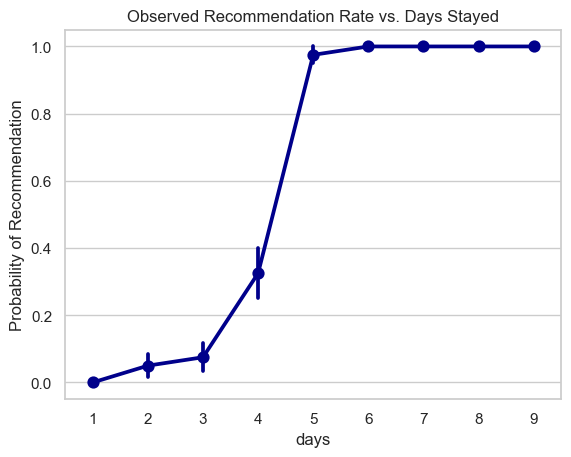

In [101]:
sns.pointplot(data=df, x="days", y="recommend", errorbar='se', color="darkblue")
plt.title("Observed Recommendation Rate vs. Days Stayed")
plt.ylabel("Probability of Recommendation")
plt.show()


In [102]:
import pymc as pm
import arviz as az

# Encode the data
X = df['days'].values
y = df['recommend'].values

with pm.Model() as complete_pooling:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=2)
    
    # Logistic function
    logit_p = alpha + beta * X
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))
    
    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)
    
    # Sampling
    trace_cp = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


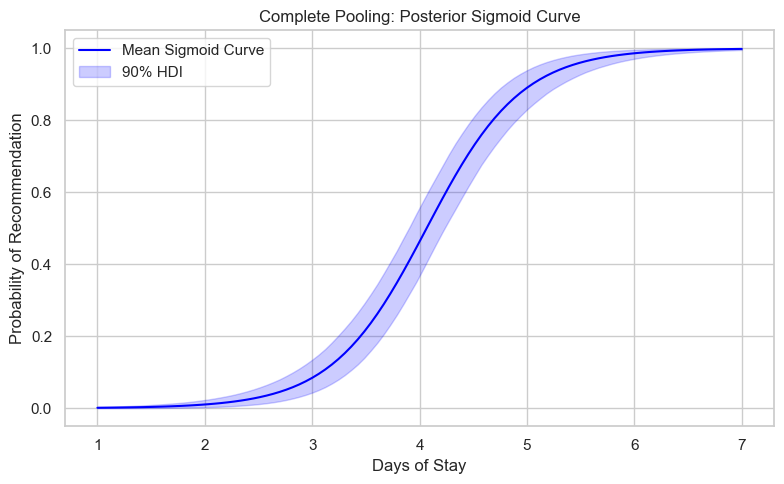

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Extract posterior samples
alpha_samples = trace_cp.posterior["alpha"].values.flatten()
beta_samples = trace_cp.posterior["beta"].values.flatten()

# Generate a range of days (1 to 7)
days_range = np.linspace(1, 7, 100)

# Compute sigmoid curves for posterior samples
sigmoid_curves = [1 / (1 + np.exp(-(a + b * days_range))) for a, b in zip(alpha_samples, beta_samples)]

# Compute the mean and 90% HDI
sigmoid_array = np.array(sigmoid_curves)
mean_curve = sigmoid_array.mean(axis=0)
lower = np.percentile(sigmoid_array, 5, axis=0)
upper = np.percentile(sigmoid_array, 95, axis=0)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(days_range, mean_curve, label="Mean Sigmoid Curve", color="blue")
plt.fill_between(days_range, lower, upper, color="blue", alpha=0.2, label="90% HDI")
plt.xlabel("Days of Stay")
plt.ylabel("Probability of Recommendation")
plt.title("Complete Pooling: Posterior Sigmoid Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Define true parameters for each city
true_params = {
    'Cartagena': {'alpha': -2.0, 'beta': 0.7},
    'Medellín': {'alpha': 0.0, 'beta': 1.0},
    'Bogotá': {'alpha': 1.0, 'beta': 1.2},
}

n_per_city = 100
days_range = np.arange(1, 15)

# Generate synthetic dataset
data = []
for city, params in true_params.items():
    for _ in range(n_per_city):
        days = np.random.choice(days_range)
        linear_term = params['alpha'] + params['beta'] * days
        prob = 1 / (1 + np.exp(-linear_term))
        recommend = np.random.binomial(1, prob)
        data.append({
            'city': city,
            'days': days,
            'recommend': recommend
        })

df = pd.DataFrame(data)


In [86]:
cities = df['city'].unique()

In [93]:
np_traces = {}
for city in cities:  # Este "cities" ahora está bien ordenado
    df_city = df[df['city'] == city]
    with pm.Model() as model_np:
        alpha = pm.Normal("alpha", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10)

        p = pm.math.sigmoid(alpha + beta * df_city['days'].values)
        y_obs = pm.Bernoulli("y_obs", p=p, observed=df_city['recommend'].values)

        trace = pm.sample(2000, tune=10000, target_accept=0.9, chains=2, return_inferencedata=True)
        np_traces[city] = trace


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 7 seconds.
There were 1638 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 4 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


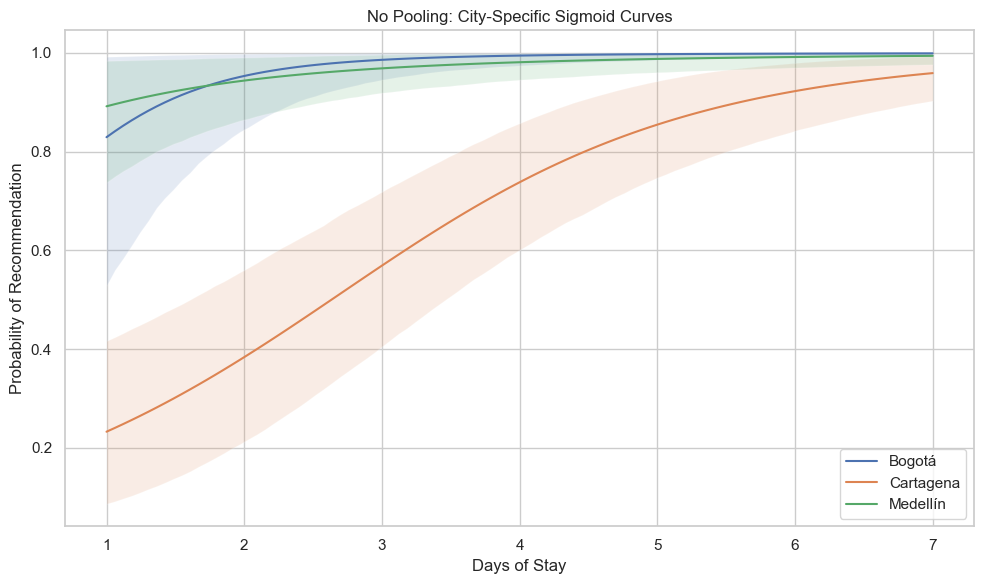

In [94]:
days_range = np.linspace(1, 7, 100)

plt.figure(figsize=(10, 6))

for city in cities:
    trace = np_traces[city]
    alpha_samples = trace.posterior["alpha"].values.flatten()
    beta_samples = trace.posterior["beta"].values.flatten()

    sigmoid_curves = [1 / (1 + np.exp(-(a + b * days_range))) for a, b in zip(alpha_samples, beta_samples)]
    sigmoid_array = np.array(sigmoid_curves)

    mean_curve = sigmoid_array.mean(axis=0)
    lower = np.percentile(sigmoid_array, 5, axis=0)
    upper = np.percentile(sigmoid_array, 95, axis=0)

    plt.plot(days_range, mean_curve, label=f"{city}")
    plt.fill_between(days_range, lower, upper, alpha=0.15)

plt.title("No Pooling: City-Specific Sigmoid Curves")
plt.xlabel("Days of Stay")
plt.ylabel("Probability of Recommendation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
# Asegurar orden correcto
df['city'] = df['city'].astype('category')
cities = df['city'].cat.categories.tolist()
df['city_code'] = df['city'].cat.codes
city_idx = df['city_code'].values

with pm.Model() as hierarchical_logistic_model:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=10)
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=10)

    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=5)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=5)

    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=len(cities))
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=len(cities))

    p = pm.math.sigmoid(alpha[city_idx] + beta[city_idx] * df['days'].values)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=df['recommend'].values)

    trace_hier = pm.sample(2000, tune=10000, target_accept=0.95, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, mu_beta, sigma_alpha, sigma_beta, alpha, beta]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 43 seconds.
There were 1791 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


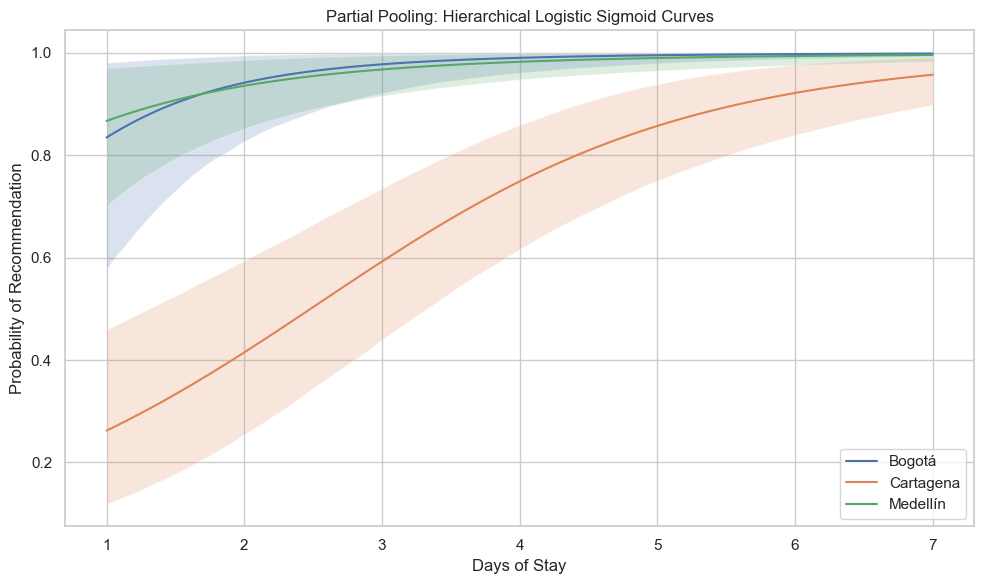

In [92]:
import matplotlib.pyplot as plt
import numpy as np

days_range = np.linspace(1, 7, 100)

plt.figure(figsize=(10, 6))

for i, city in enumerate(cities):
    alpha_samples = trace_hier.posterior["alpha"].sel(alpha_dim_0=i).values.flatten()
    beta_samples = trace_hier.posterior["beta"].sel(beta_dim_0=i).values.flatten()

    sigmoid_curves = [1 / (1 + np.exp(-(a + b * days_range))) for a, b in zip(alpha_samples, beta_samples)]
    sigmoid_array = np.array(sigmoid_curves)

    mean_curve = sigmoid_array.mean(axis=0)
    lower = np.percentile(sigmoid_array, 5, axis=0)
    upper = np.percentile(sigmoid_array, 95, axis=0)

    plt.plot(days_range, mean_curve, label=f"{city}")
    plt.fill_between(days_range, lower, upper, alpha=0.2)

plt.title("Partial Pooling: Hierarchical Logistic Sigmoid Curves")
plt.xlabel("Days of Stay")
plt.ylabel("Probability of Recommendation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib
def plot_city_spending(df, model_means, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='city', y='spending', data=df, color='lightgray')

    # Observed means
    observed_means = df.groupby("city")["spending"].mean()
    for i, city in enumerate(observed_means.index):
        plt.scatter(i, observed_means[city], color='black', label="Observed Mean" if i == 0 else "", zorder=10)

    # Model means (green)
    for i, city in enumerate(model_means.index):
        plt.scatter(i, model_means[city], color='green', label=r"Model Mean $\hat{y}$" if i == 0 else "", zorder=10)

    plt.ylabel("Total Spending (USD)")
    plt.title(title)
    plt.legend()
    plt.show()


Using matplotlib backend: module://matplotlib_inline.backend_inline
